In [465]:
import pandas as pd
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import ast
from kmodes.kprototypes import KPrototypes
from kmodes.kmodes import KModes
from collections import Counter
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from gower import gower_matrix
from utils import multiple_graphs
from prince import MCA, FAMD
from hyperopt import fmin, tpe, hp, Trials
%matplotlib inline

In [466]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="using precomputed metric; inverse_transform will be unavailable")

## Предварительная обработка датасета

In [467]:
df = pd.read_csv('Result_21_5.csv')

# Делаем преобразования некоторых полей, с помощью библиотеки ast после импорта из csv
for col in df.drop(['profile_id', 'geo'], axis=1).select_dtypes(include='object').columns:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])

print(df.shape)    
df.head()

(7845, 14)


,profile_id,profile_is_child,geo,product_ids,device,delta,positive,negative,genres,hashtags,cls,starts,progress,versions
0,80d6ad93-1aa3-40dd-9f85-1bee3f2a8627,0,RU,[c164dd6d-3669-435c-a8f6-b57ca14b0a61],[web],29193298,0,0,"[criminal, drama, action]","[Законы улиц, Кино с характером, Криминальные ...",[Series],[2024-01-22 18:35:28],[1.1449645],[2024-01-22 19:20:38]
1,0cec5794-90fa-467d-9857-43851054dfb3,0,BY,"[608da742-46c3-4a5d-8134-532fd391a456, c0c4fa9...","[tv, tv, tv, tv, tv, tv, tv, tv, tv, tv, tv, t...",590977773,0,0,"[detective, drama, comedy, family, thriller, d...","[Ведется расследование, Мрачная атмосфера, Тай...","[Series, Series, Movie, Series, Series, Series...","[2023-12-22 14:52:55, 2025-03-16 14:13:35, 202...","[0.95737725, 0.014767603, 0.013667554, 0.21475...","[2023-12-22 14:52:55, 2025-03-16 14:17:38, 202..."
2,50820849-495c-4eab-8531-71b294585d3a,0,RU,"[55b61165-1d6d-4216-80f8-95ffda3bd528, e3885f6...","[web, web, web, web, web]",36432828,11,4,"[comedy, family, family, fantasy, adventure, c...","[Вечные ценности, Дела семейные, Душевное, Жиз...","[Series, Series, Series, Series, Series]","[2024-11-19 17:33:47, 2024-10-13 18:33:56, 202...","[0.09395181, 0.8115045, 0.0010829378, 0.000202...","[2024-11-19 18:21:13, 2024-10-13 18:34:17, 202..."
3,0121c8ec-2066-4aa7-a788-db9e6abb65a5,1,RU,[2b085cca-54e2-44ac-b437-ee7607828d1d],[tv],2098083,0,0,"[entertainment, cartoonseries]","[Малышам, Про дружбу, Девочкам]",[Series],[2024-12-03 04:10:59],[0.12762572],[2024-12-03 04:47:59]
4,97de2898-7245-4430-9eaa-1217a7476cc7,0,DE,"[b315e3c5-da4b-4dc7-bc01-62d7761e732d, 608da74...","[mobile, mobile, mobile, mobile, mobile, mobil...",38886428,0,0,"[drama, detective, drama, detective, melodrama...","[Звездный актерский состав, Советское время, О...","[Series, Series, Series, Series, Series, Serie...","[2023-12-17 13:52:34, 2023-11-18 21:47:18, 202...","[0.009468423, 0.012955979, 0.037663378, 0.0026...","[2023-12-17 13:52:41, 2023-11-18 21:51:17, 202..."


In [468]:
# Определяем самые часто встречающиеся значения в колонках device, genres, hashtags, cls, если таких значений больше одного
# то заменяем их значением "various". Это позволит избежать большого разброса данных.
def most_frequent(row):        
    counts = Counter(row)
    data = [i for i, v in zip(counts.keys(), counts.values()) if v == max(counts.values())]
    if len(data) > 1:
        return 'various'
    return ''.join(data)
for col in ['device', 'genres', 'hashtags', 'cls']:
    df[col] = df[col].apply(most_frequent)
    
# Обрабатываем временные данные. Преобразуем время начала просмотра в колонке "starts" в категории утро, день, вечер, ночь
# и определим самые часто встречающиеся значения. Это также позволит избежать большого разброса данных.

def time_of_day(h):
    if 5 <= h < 11: return 'Morning'
    elif 11 <= h < 17: return 'Day'
    elif 17 <= h < 23: return 'Evening'
    else: return 'Night'

# Делаем категориальный признак - наиболее частое количество просмотров утром, днем вечером или ночью 
df['period'] =  df['starts'].apply(
    lambda times: [time_of_day(pd.to_datetime(t, format='%Y-%m-%d %H:%M:%S', errors='coerce').hour) for t in times if t]
).apply(most_frequent)

# Сделаем еще один категориальный признак наиболее часто встречающиеся просмотры по дням недели (будни / выходные)
df['weekdays'] = df['starts'].apply(
    lambda times: [
        'weekend' if pd.to_datetime(t, format='%Y-%m-%d %H:%M:%S', errors='coerce').weekday() in [5, 6] else 'weekdays'
        for t in times if t
    ]
).apply(most_frequent)

# Сделаем числовой признак - количество просмотров
df['views_count'] = df['product_ids'].apply(lambda x: len(x))
df['progress'] = df['progress'].map(lambda x: list(pd.to_numeric(x, errors='coerce')))

# Сделаем числовой признак - средний прогресс по просмотрам продуктов
df['mean_progress'] = df['progress'].apply(np.mean)

# Разделение признаков на числовые и категориальные
num_cols = df.drop('profile_is_child', axis=1).select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.drop(list(num_cols)+['profile_id', 'product_ids', 'starts', 'versions', 'progress'], axis=1).columns
df.head(10)

,profile_id,profile_is_child,geo,product_ids,device,delta,positive,negative,genres,hashtags,cls,starts,progress,versions,period,weekdays,views_count,mean_progress
0,80d6ad93-1aa3-40dd-9f85-1bee3f2a8627,0,RU,[c164dd6d-3669-435c-a8f6-b57ca14b0a61],web,29193298,0,0,various,various,Series,[2024-01-22 18:35:28],[1.1449645],[2024-01-22 19:20:38],Evening,weekdays,1,1.144964
1,0cec5794-90fa-467d-9857-43851054dfb3,0,BY,"[608da742-46c3-4a5d-8134-532fd391a456, c0c4fa9...",tv,590977773,0,0,comedy,С субтитрами для слабослышащих,Series,"[2023-12-22 14:52:55, 2025-03-16 14:13:35, 202...","[0.95737725, 0.014767603, 0.013667554, 0.21475...","[2023-12-22 14:52:55, 2025-03-16 14:17:38, 202...",Evening,weekdays,52,0.557868
2,50820849-495c-4eab-8531-71b294585d3a,0,RU,"[55b61165-1d6d-4216-80f8-95ffda3bd528, e3885f6...",web,36432828,11,4,comedy,various,Series,"[2024-11-19 17:33:47, 2024-10-13 18:33:56, 202...","[0.09395181, 0.8115045, 0.0010829378, 0.000202...","[2024-11-19 18:21:13, 2024-10-13 18:34:17, 202...",Evening,weekend,5,0.276548
3,0121c8ec-2066-4aa7-a788-db9e6abb65a5,1,RU,[2b085cca-54e2-44ac-b437-ee7607828d1d],tv,2098083,0,0,various,various,Series,[2024-12-03 04:10:59],[0.12762572],[2024-12-03 04:47:59],Night,weekdays,1,0.127626
4,97de2898-7245-4430-9eaa-1217a7476cc7,0,DE,"[b315e3c5-da4b-4dc7-bc01-62d7761e732d, 608da74...",mobile,38886428,0,0,detective,Ведется расследование,Series,"[2023-12-17 13:52:34, 2023-11-18 21:47:18, 202...","[0.009468423, 0.012955979, 0.037663378, 0.0026...","[2023-12-17 13:52:41, 2023-11-18 21:51:17, 202...",Evening,weekend,7,0.225209
5,1311d3ed-5b60-409b-aaa1-051ea168b417,1,RU,"[59844624-773b-4f5b-830f-94329a16f6dd, b59aef3...",tv,33960700,0,0,various,various,Movie,"[2023-12-17 05:12:37, 2023-12-20 04:28:44, 202...","[0.9512784, 0.08321342, 1.9006531, 0.63359153,...","[2023-12-17 06:26:54, 2023-12-20 04:32:32, 202...",Night,weekdays,7,1.166956
6,7790b042-869f-42a9-81a3-4915ebb5daf3,1,GB,"[1564d800-1fb2-452b-82ee-6b4c88672b9e, fbe6a8e...",tv,172518557,94,1,various,various,various,"[2024-10-08 05:44:32, 2024-10-18 15:24:37]","[1.6096299, 0.0007869071]","[2024-10-08 07:02:17, 2024-10-18 15:24:37]",various,weekdays,2,0.805208
7,9cb292df-54be-4095-9c39-567dc34d4853,0,RU,[c5c4155f-84b2-4d42-8f70-5771b7ceaaea],web,45781493,0,0,various,various,Series,[2023-07-22 11:08:44],[0.042432778],[2023-07-22 13:23:02],Day,weekend,1,0.042433
8,b86634de-9941-4fd4-942b-7ecf945d9103,0,RU,"[be95c08d-50a5-462f-8c31-ff68109933df, 278251a...",mobile,73823000,0,0,drama,various,Series,"[2023-12-10 12:28:47, 2023-12-11 10:09:23, 202...","[0.27907428, 0.0006376738, 0.13253012, 0.47698...","[2023-12-10 13:02:35, 2023-12-11 10:09:36, 202...",Night,weekdays,4,0.222307
9,48e7461d-647a-4a70-aa42-5b3e67a29bdb,0,GB,"[bc548cdd-1314-4634-9da6-446efbea0758, 999878e...",tv,404000,0,0,various,various,Series,"[2023-07-07 08:40:36, 2023-10-31 20:18:57]","[0.0012705132, 0.004426466]","[2023-07-07 08:41:32, 2023-10-31 20:18:57]",various,weekdays,2,0.002848


## Анализ датасета
### Числовые признаки

In [469]:
def bar_box_plot(data: pd.DataFrame):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    sns.barplot(data=data, ax=ax1)
    ax1.set_title('Средние значения признаков')
    sns.boxplot(x='Features', y='Values', data=data.melt(var_name='Features', value_name='Values'), ax=ax2)
    ax2.set_title('Распределение признаков')
    plt.show()

Проверяем числовые признаки на корреляцию, строим тепловую карту

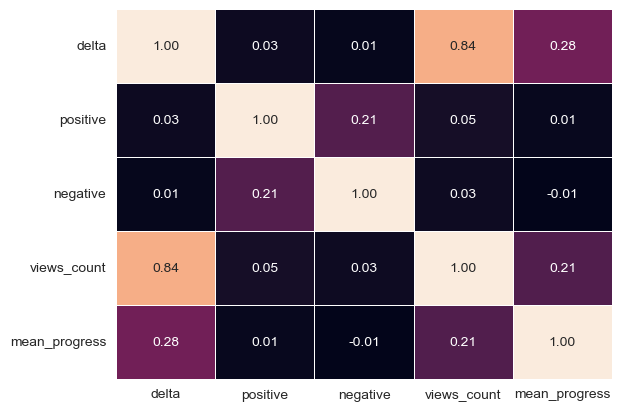

In [470]:
sns.heatmap(df[num_cols].corr(), annot=True, cbar=False, linewidths=.5, fmt= '.2f')
plt.show()

Видим, что views_count(число просмотров) и delta(общая длительность просмотров) сильно скоррелированы, поэтому один признак можно убрать. Убираю delta (общая длительность просмотров в секундах).

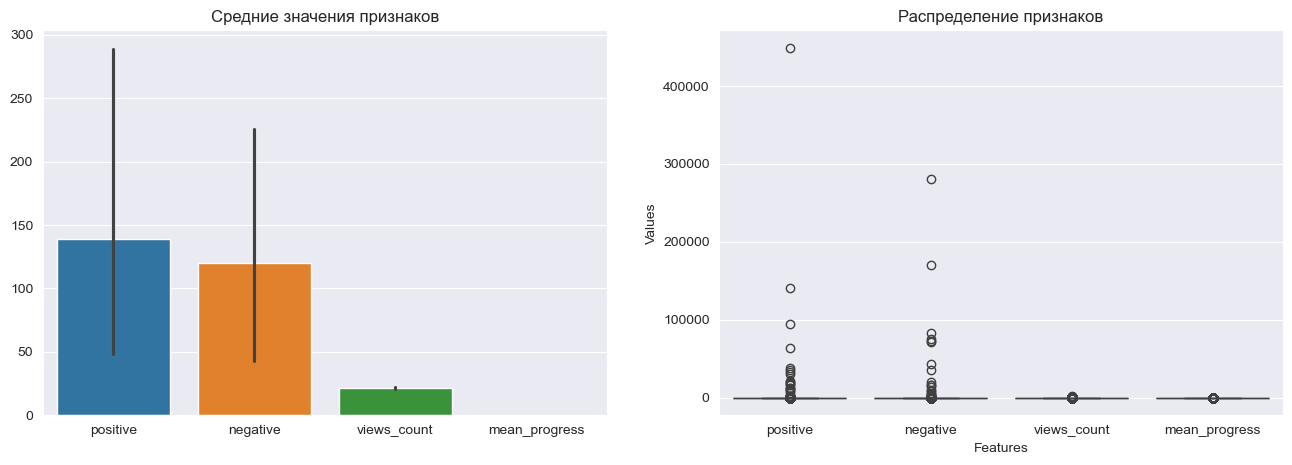

In [471]:
num_cols = num_cols.drop(['delta'])
bar_box_plot(df[num_cols])

Наблюдаем очень большой разброс и большое количество выбросов в числовых признаках. Необходимо сделать нормализацию числовых данных. Стандартизация для k-prototypes не подходит, т.к. Z-score создает отрицательные значения, что усложняет интерпретацию центроидов и может давать артефакты при расчете расстояний

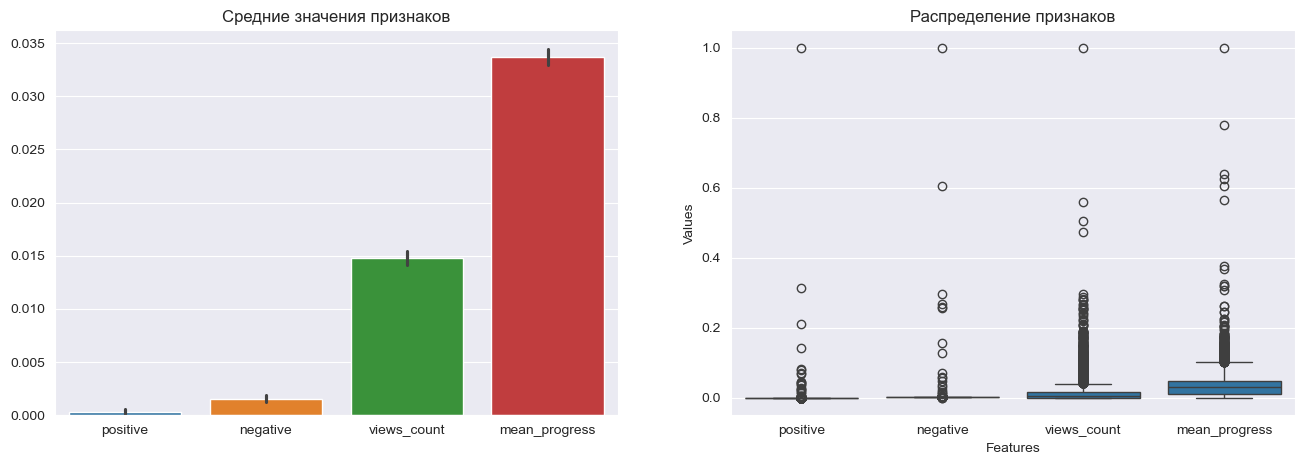

In [472]:
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
bar_box_plot(df[num_cols])

### Категориальные признаки

In [473]:
df[cat_cols].head()

,profile_is_child,geo,device,genres,hashtags,cls,period,weekdays
0,0,RU,web,various,various,Series,Evening,weekdays
1,0,BY,tv,comedy,С субтитрами для слабослышащих,Series,Evening,weekdays
2,0,RU,web,comedy,various,Series,Evening,weekend
3,1,RU,tv,various,various,Series,Night,weekdays
4,0,DE,mobile,detective,Ведется расследование,Series,Evening,weekend


Смотрим количество уникальных значений в каждой колонке

In [474]:
df[cat_cols].nunique()

profile_is_child     2
geo                 64
device               4
genres              22
hashtags            92
cls                  3
period               5
weekdays             3
dtype: int64

Удаляем самые большие значения - geo и hashtags, так как большое количество категориальных признаков может привести к проблемам с выбором центроидов, переобучению и сложности в интерпретации кластеров


In [475]:
cat_cols = cat_cols.drop(['geo', 'hashtags'])

Построим график распределения кластеров

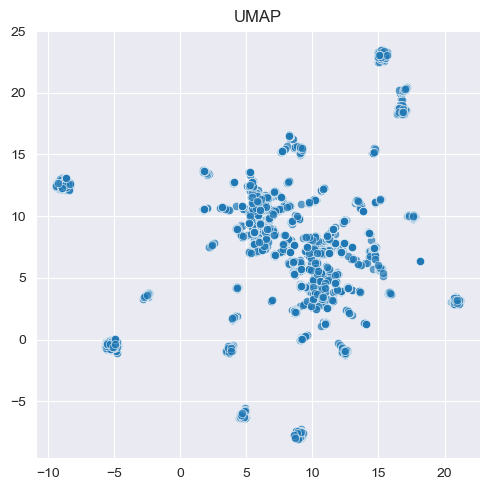

In [476]:
def draw_clusters(dataframe: pd.DataFrame):
    encoder = OneHotEncoder(sparse_output=False)
    encoded = encoder.fit_transform(dataframe)
    reducer = umap.UMAP()
    emb = reducer.fit_transform(encoded)
    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        x=emb[:, 0],
        y=emb[:, 1],
        alpha=0.7
    )
    plt.title('UMAP')
    plt.tight_layout()
    plt.show()
draw_clusters(df[cat_cols])

Видно что кое-где образовываются кластеры, но в основном картина печальная

## Обучение K-modes

K-modes используeтся для кластеризации категориальных переменных. Он определяет кластеры на основе количества категорий сопоставления между точками данных. (Это в отличие от более известного алгоритма k-means, который кластеры складывает численные данные, основанные на евклидовом расстоянии.) <br> Алгоритм k-prototypes сочетает в себе k-modes и k-means и способен кластерировать смешанные числовые / категориальные данные.

Обучим модель k-modes "из коробки" на 10-ти кластерах и посчитаем метрику silhouette_score
Возьмем следующие метрики: <br>
Силуэтный коэффициент (Silhouette Score): Этот коэффициент измеряет, насколько объект похож на свой кластер по сравнению с соседними кластерами. Значение от +1 до -1, где 1 подразумевает, что объект правильно классифицирован, 0 указывает на сопредельные кластеры, а -1 означает, что он был неправильно отнесен к кластеру. Силуэтный коэффициент полезен для оценки и сравнения различных кластеризаций. <br>
Коэффициент Калински-Харабаза (Calinski-Harabasz Index): Этот индекс измеряет соотношение между внутрикластерной дисперсией и межклассовой дисперсией. Более высокие значения этого индекса указывают на более качественные кластеризации. <br>
Индекс Дэвиса-Боулдина (Davies-Bouldin Index): Он измеряет среднее отношение между внутрикластерными расстояниями и межкластерными расстояниями. Более низкие значения индекса указывают на лучшее качество кластеризации.

In [477]:
# Делаем функцию для подсчета метрик, в которой используем матрицу Говера. Матрица Говера - это мера сходства между объектами
# (или строками) в данных, которая учитывает не только числовые, но и категориальные переменные. Она позволяет вычислить матрицы 
# расстояний между объектами с использованием различных типов данных.

def scores_calc(dataframe, clrs, metric):
    gm = gower_matrix(dataframe)
    shi = silhouette_score(gm, clrs, metric=metric)
    chi = calinski_harabasz_score(gm, clrs)
    dbi = davies_bouldin_score(gm, clrs)
    return shi, chi, dbi

# Так как очень большой датасет, для экономии времени делаем выборку
num_rows = 900
X = df[cat_cols].head(num_rows)

# Делаем KModes из коробки
km = KModes(n_jobs=-1)
clusters = km.fit_predict(X)
scores = scores_calc(X, clusters, 'hamming')
print(f"Silhouette Score: {scores[0]} \nCalinski-Harabasz Score: {scores[1]}\nDavies-Bouldin Score: {scores[2]}")

Silhouette Score: 0.06028447192087686 
Calinski-Harabasz Score: 63.79015041489816
Davies-Bouldin Score: 2.1386667566729947


Все метрики плохие, в частности очень низкий показатель Silhouette Score, нормальные результаты начинаются когда s_score > 0.5, а хорошие при s_score > 0.7.
Попробуем найти самые важные признаки и убрать менее значимые. 
Для этого используем библиотеку prince https://maxhalford.github.io/prince/ и класс MCA, работающий с категориальными признаками

In [478]:
cat_data = df[cat_cols]
# mca = MCA(n_components=len(cat_cols), n_iter=10, random_state=42, engine='sklearn')
mca = MCA(n_components=2, n_iter=10, random_state=42, engine='sklearn')

mca = mca.fit(cat_data)
modality_contributions = mca.column_contributions_
explained_inertia = mca.eigenvalues_
# modality_contributions


dummy_to_feat = [col.split('_')[0] for col in modality_contributions.index]

feat_importance = {}
for feat in set(dummy_to_feat):
    idx = [i for i,f in enumerate(dummy_to_feat) if f == feat]
    m = modality_contributions.iloc[idx,:].values
    imp = np.sum(np.abs(m) * explained_inertia, axis=1).sum()
    feat_importance[feat] = imp
feat_importance = pd.Series(feat_importance).sort_values(ascending=False)
print(feat_importance)

genres      0.141454
profile     0.115044
weekdays    0.076130
period      0.068834
cls         0.067103
device      0.043542
dtype: float64


In [479]:
# cat_data = df[cat_cols].head(num_rows)
# mca = MCA(n_components=len(cat_data.columns), n_iter=10, random_state=42, engine='sklearn')
# mca = mca.fit(cat_data)
# eigenvalues = mca.eigenvalues_
# columns = cat_data.columns
# importance_df = pd.DataFrame({
#     'Feature': columns,
#     'Eigenvalue': eigenvalues
# }).sort_values(by='Eigenvalue', ascending=False)
# importance_df

Видим, что временные данные period (время просмотра - утро, день, вечер, ночь) и weekdays (время просмотра - будни, выходные), в рейтинге на последних местах. Удалим их

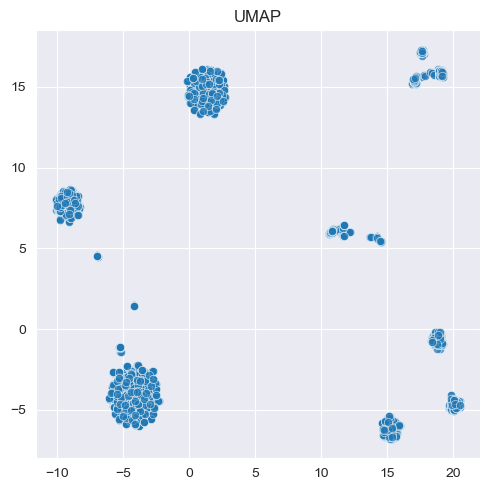

In [480]:
# final_cat_cols = cat_cols.drop(['period', 'weekdays'])
final_cat_cols = cat_cols.drop(['cls', 'device', 'period'])
# final_cat_cols = cat_cols.drop(['cls', 'device'])
draw_clusters(df[final_cat_cols])

Видим на визуализации уже вполне отчетливые кластеры. Проведем повторную оценку кластеров

In [481]:
X = df[final_cat_cols].head(num_rows)
km = KModes(n_jobs=-1)
clusters = km.fit_predict(X)
scores = scores_calc(X, clusters, 'hamming')
print(f"Silhouette Score: {scores[0]} \nCalinski-Harabasz Score: {scores[1]}\nDavies-Bouldin Score: {scores[2]}")

Silhouette Score: 0.5591049916679685 
Calinski-Harabasz Score: 402.1049065054305
Davies-Bouldin Score: 0.7377681153856234


Видим, что Silhouette Score стал выше.
Сделаем оптимизацию гиперпараметра n_clusters

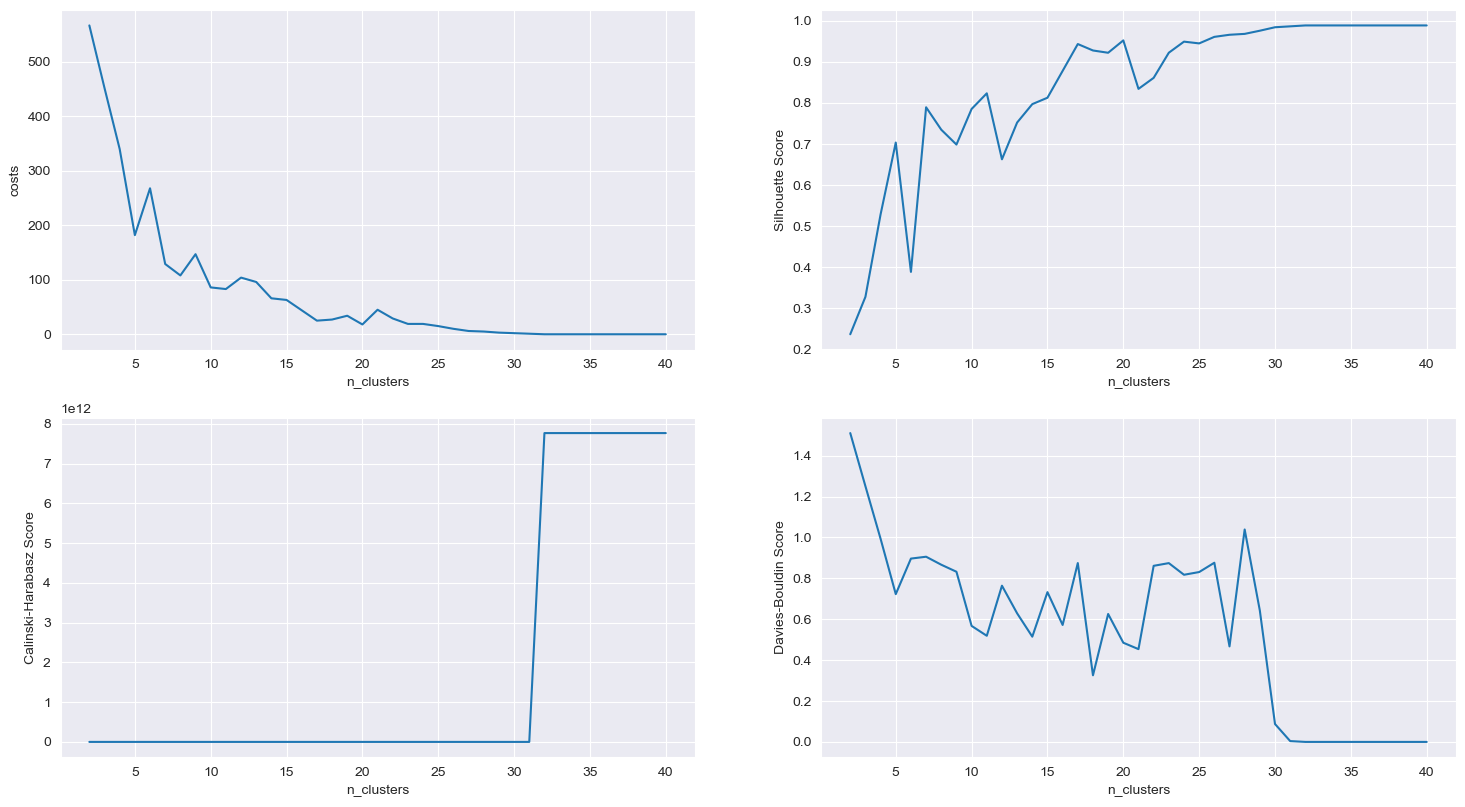

In [482]:
n_clusters = []
costs = []
s_scores =  []
ch_scores = []
db_scores = []
K = range(2, 41)
for k in K:
    km = KModes(n_clusters=k, init='Huang', n_init=2, verbose=0, random_state=42, n_jobs=-1)
    n_clusters.append(k)
    clusters = km.fit_predict(X)
    costs.append(km.cost_)
    metrics = scores_calc(X, clusters, 'hamming')
    s_scores.append(metrics[0])
    ch_scores.append(metrics[1])
    db_scores.append(metrics[2])
    
train_results = pd.DataFrame({'n_clusters':n_clusters, 'costs': costs, 'Silhouette Score': s_scores, 'Calinski-Harabasz Score': ch_scores, 'Davies-Bouldin Score':db_scores})
multiple_graphs(2, 'n_clusters', train_results)

Из графиков не особо понятно, какой минимум кластеров надо взять. Повторим оптимизацию с помощью библиотеки hyperopt, определим минимальное количество кластеров.

In [483]:
def objective_modes(params):
    n_clrs = int(params['n_clusters'])
    init = params['init']
    model = KModes(n_clusters=n_clrs, init=init, n_init=2, random_state=42)
    clrs = model.fit_predict(X)
    cost = model.cost_
    # штраф за большое количество кластеров
    penalty = 0.1 * n_clrs
    
    ss, chs, dbi = scores_calc(X, clrs, 'hamming')
    return {
        'loss': cost + penalty, 
        'status': 'ok', 
        'n_clusters': n_clrs, 
        'cost': cost, 
        'silhouette': ss,
        'calinski_harabasz': chs,
        'davies_bouldin' :dbi
    }
space = {
    'n_clusters': hp.choice('n_clusters', range(2, 40)),
    'init': hp.choice('init', ['Huang', 'Cao']),
}

trials = Trials()
best = fmin(fn=objective_modes, space=space, algo=tpe.suggest, max_evals=40, trials=trials)
print(f"Лучшие гиперпараметры:\n{trials.best_trial['result']}")
# Пишем минимум кластеров в переменную
n_kmodes = trials.best_trial['result']['n_clusters']

100%|██████████| 40/40 [00:18<00:00,  2.16trial/s, best loss: 3.2]               
Лучшие гиперпараметры:
{'loss': 3.2, 'status': 'ok', 'n_clusters': 32, 'cost': 0.0, 'silhouette': 0.9888888888888889, 'calinski_harabasz': 7770062017859.559, 'davies_bouldin': 2.2138272728437182e-06}


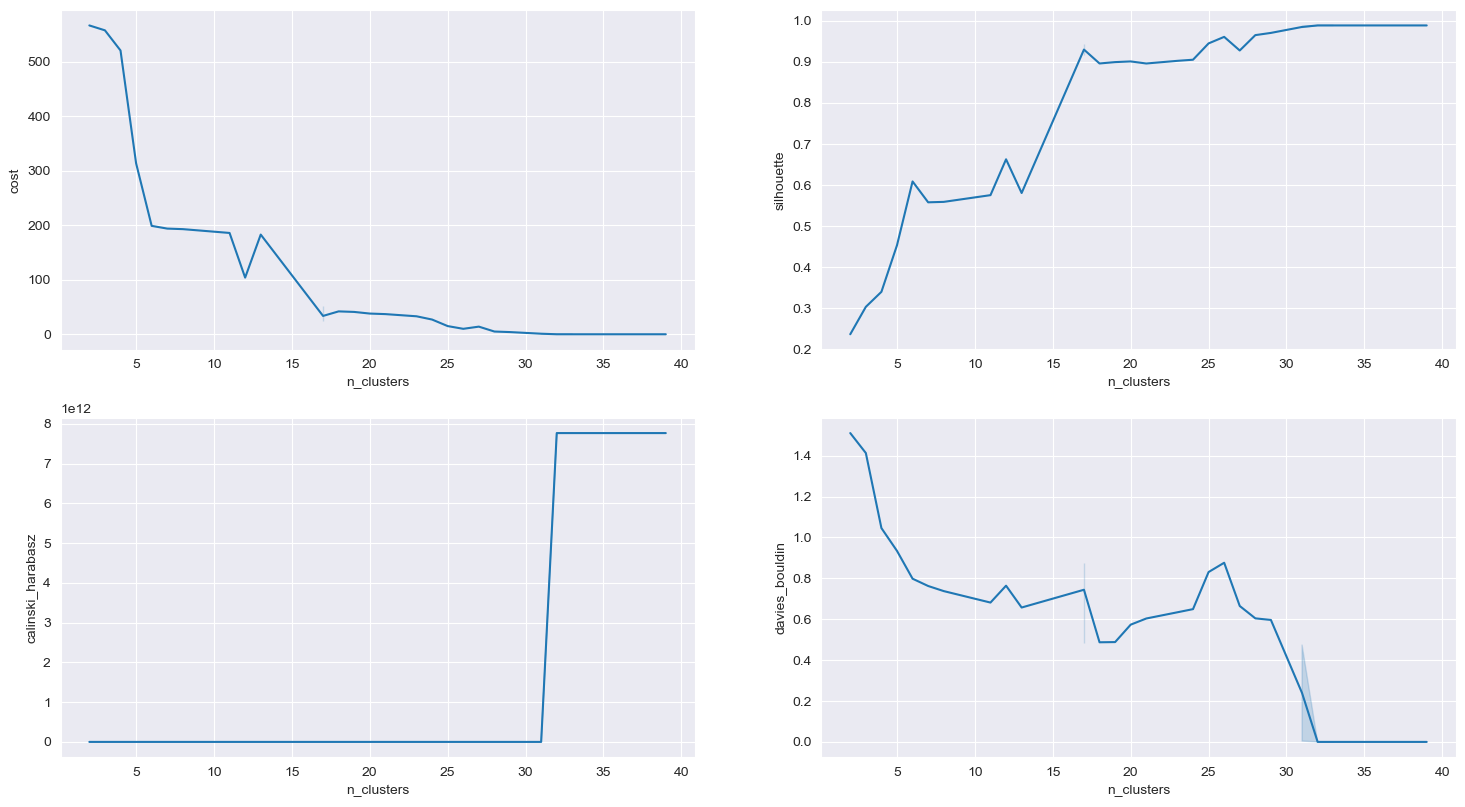

In [484]:
multiple_graphs(2, 'n_clusters', pd.DataFrame(trials.results).sort_values('loss').drop(['status', 'loss'], axis=1))

Получили минимальное количество кластеров. Проведем заново оценку.

In [485]:
km = KModes(n_clusters=n_kmodes, init='Huang', n_jobs=-1, random_state=42)
clusters = km.fit_predict(X)
scores = scores_calc(X, clusters, 'hamming')
print(f"Silhouette Score: {scores[0]} \nCalinski-Harabasz Score: {scores[1]}\nDavies-Bouldin Score: {scores[2]}")

Silhouette Score: 0.9888888888888889 
Calinski-Harabasz Score: 7770062017859.559
Davies-Bouldin Score: 2.2138272728437182e-06


Метрики значительно улучшились. Но попробуем получить меньшее количество кластеров при сравнимых метриках.

## Обучение K-prototypes
Сделаем визуализацию кластеров на смешанных признаках

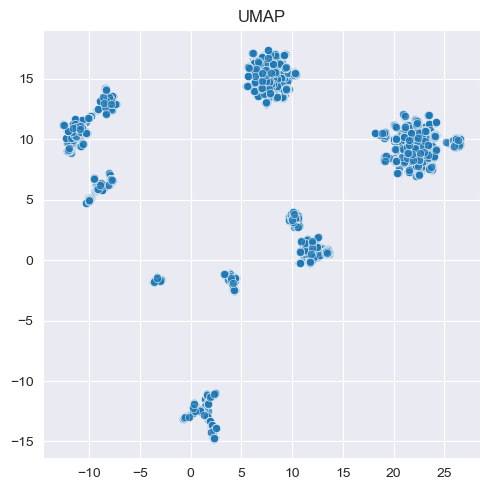

In [486]:
combined_cols = final_cat_cols.append(num_cols)
draw_clusters(df[combined_cols])

Видим вполне отчетливые кластеры.
Проведем оценку важности смешанных признаков с помощью класса FAMD из библиотеки prince

In [487]:
from prince import PCA
pca = PCA(n_components=len(df[num_cols].columns), rescale_with_mean=True, rescale_with_std=True, random_state=42, engine='sklearn')
pca.fit(df[num_cols])
loadings = pca.column_correlations
explained_var = pca.eigenvalues_
feature_importance = (np.abs(loadings).multiply(explained_var, axis=1)).sum(axis=1)
feature_importance = feature_importance.sort_values(ascending=False)
feature_importance

variable
positive         1.927156
mean_progress    1.906703
views_count      1.875492
negative         1.857918
dtype: float64

In [488]:
# combined_data = df[combined_cols].head(num_rows)
# fmd = FAMD(n_components=len(combined_data.columns), n_iter=3, check_input=True, random_state=42, engine='sklearn', handle_unknown="error")
# fmd = fmd.fit(combined_data)
# eigenvalues = fmd.eigenvalues_
# columns = combined_data.columns
# importance_combined_df = pd.DataFrame({
#     'Feature': columns,
#     'Eigenvalue': eigenvalues
# }).sort_values(by='Eigenvalue', ascending=False)
# importance_combined_df

Удалим наименее важные признаки из числовых и категориальных

In [489]:

# final_combined_cols = combined_cols.drop(['cls', 'mean_progress'])
final_combined_cols = combined_cols.drop(['', 'negative'])
X = df[final_combined_cols].head(num_rows)
X.head()

,profile_is_child,genres,weekdays,positive,views_count,mean_progress
0,0,various,weekdays,0.000000,0.000000,0.104503
1,0,comedy,weekdays,0.000000,0.037091,0.050917
2,0,comedy,weekend,0.000024,0.002909,0.025241
3,1,various,weekdays,0.000000,0.000000,0.011649
4,0,detective,weekend,0.000000,0.004364,0.020555


Обучим k-prototypes из коробки

In [490]:
# k-prototypes требует указания категориальных признаков
cats = [0, 1, 2]
k_proto = KPrototypes(n_jobs=-1)
clusters = k_proto.fit_predict(X, categorical=cats)
scores = scores_calc(X, clusters, metric="precomputed")
print(f"Silhouette Score: {scores[0]} \nCalinski-Harabasz Score: {scores[1]}\nDavies-Bouldin Score: {scores[2]}")

Silhouette Score: 0.6250081658363342 
Calinski-Harabasz Score: 552.1592377435779
Davies-Bouldin Score: 1.4971979741278019


Получили уже неплохой Silhouette Score. Сделаем оптимизацию минимума кластеров с hyperopt.

In [491]:
def objective_proto(params):
    n_clrs = int(params['n_clusters'])
    try:
        model = KPrototypes(n_clusters=n_clrs, init='Huang', random_state=42, n_jobs=-1)
        clrs = model.fit_predict(X, categorical=cats)
        cost = model.cost_
        penalty = 0.1 * n_clrs
        ss, chs, dbi = scores_calc(X, clrs, 'precomputed')
        return {
            'loss': cost + penalty,
            'status': 'ok', 
            'n_clusters': n_clrs, 
            'cost': cost, 
            'silhouette': ss,
            'calinski_harabasz': chs,
            'davies_bouldin': dbi
        }
    except Exception as e:
        print(e)
        return {'loss': float('inf'), 'status': 'fail'}
space = {
    'n_clusters': hp.choice('n_clusters', range(2, 35)),
}

trials = Trials()
best = fmin(fn=objective_proto, space=space, algo=tpe.suggest, max_evals=35, trials=trials)
print(f"Лучшие гиперпараметры:\n{trials.best_trial['result']}")
n_proto = trials.best_trial['result']['n_clusters']

Clustering algorithm could not initialize. Consider assigning the initial clusters manually.
Clustering algorithm could not initialize. Consider assigning the initial clusters manually.
100%|██████████| 35/35 [01:30<00:00,  2.58s/trial, best loss: 2.866925478851349] 
Лучшие гиперпараметры:
{'loss': 2.866925478851349, 'status': 'ok', 'n_clusters': 12, 'cost': 1.6669254788513486, 'silhouette': 0.5922613, 'calinski_harabasz': 761.5737976431808, 'davies_bouldin': 1.2637497863556568}


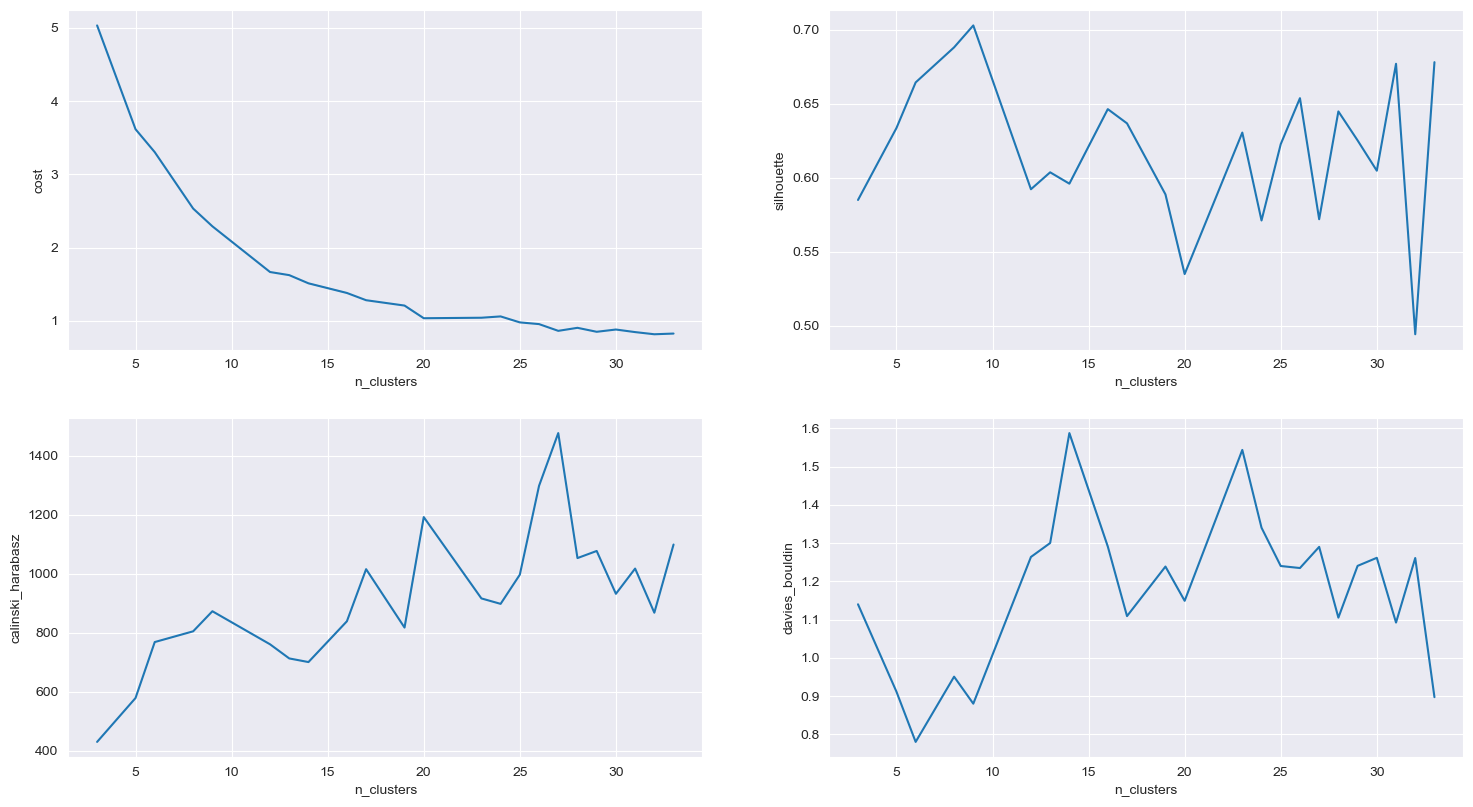

In [492]:
multiple_graphs(2, 'n_clusters', pd.DataFrame(trials.results).sort_values('loss').drop(['status', 'loss'], axis=1))

Подберем еще один важный гипермпараметр gamma, это весовой коэффициент, который определяет баланс между числовыми и категориальными признаками при вычислении расстояний между объектами. Он играет ключевую роль в кластеризации смешанных данных.

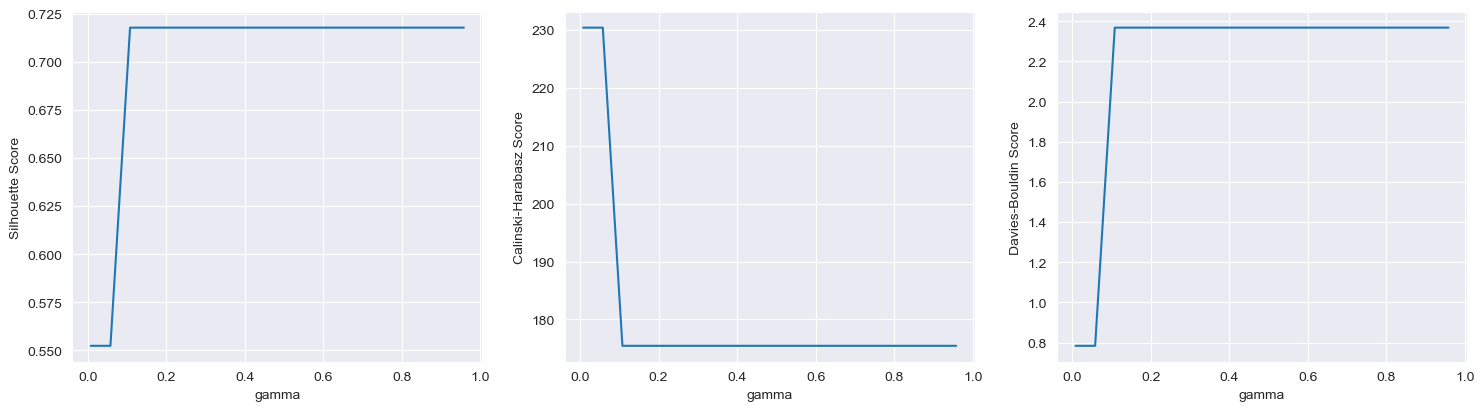

In [493]:
X_cross = X.head(300)
gammas = []
s_scores =  []
ch_scores = []
db_scores = []
for gamma in np.arange(0.008, 1, 0.05):
    k_proto = KPrototypes(n_clusters=15, init='Huang', random_state=42, n_jobs=-1, gamma=round(gamma, 2))
    clusters = k_proto.fit_predict(X_cross, categorical=cats)
    gammas.append(gamma)
    metrics = scores_calc(X_cross, clusters, 'precomputed')
    s_scores.append(metrics[0])
    ch_scores.append(metrics[1])
    db_scores.append(metrics[2])
test_results = pd.DataFrame({'gamma':gammas, 'Silhouette Score': s_scores,'Calinski-Harabasz Score': ch_scores, 'Davies-Bouldin Score': db_scores })
multiple_graphs(3, 'gamma', test_results)

Из графиков видим, что оптимальный gamma где-то 0.06, только Calinski-Harabasz Score почему-то падает при увеличении gamma.
Опустим этот факт и обучим модель на полученных параметрах и сравним с k-modes.

In [494]:
X_km = df[final_cat_cols].tail(1500)
km = KModes(n_clusters=n_kmodes, random_state=42, init='Huang', n_jobs=-1)
km_clusters = km.fit_predict(X_km)
km_scores = scores_calc(X_km, km_clusters, 'hamming')
print(f"Silhouette Score: {km_scores[0]} \nCalinski-Harabasz Score: {km_scores[1]}\nDavies-Bouldin Score: {km_scores[2]}")

Silhouette Score: 0.9887136132102542 
Calinski-Harabasz Score: 29882.327301790174
Davies-Bouldin Score: 0.04549335739351584


In [495]:
X_kp = df[final_combined_cols].tail(1500)
k_proto = KPrototypes(n_jobs=-1, random_state=42, n_clusters=n_proto, init = 'Huang', gamma=.06)
kp_clusters = k_proto.fit_predict(X_kp, categorical=cats)
kp_scores = scores_calc(X_kp, kp_clusters, metric="precomputed")
print(f"Silhouette Score: {kp_scores[0]} \nCalinski-Harabasz Score: {kp_scores[1]}\nDavies-Bouldin Score: {kp_scores[2]}")

Silhouette Score: 0.8633937239646912 
Calinski-Harabasz Score: 2372.2367866765253
Davies-Bouldin Score: 0.8940519378922477


In [496]:
print(f'минимум кластеров k-modes: {n_kmodes},\nминимум кластеров k-prototypes: {n_proto}')

минимум кластеров k-modes: 32,
минимум кластеров k-prototypes: 12


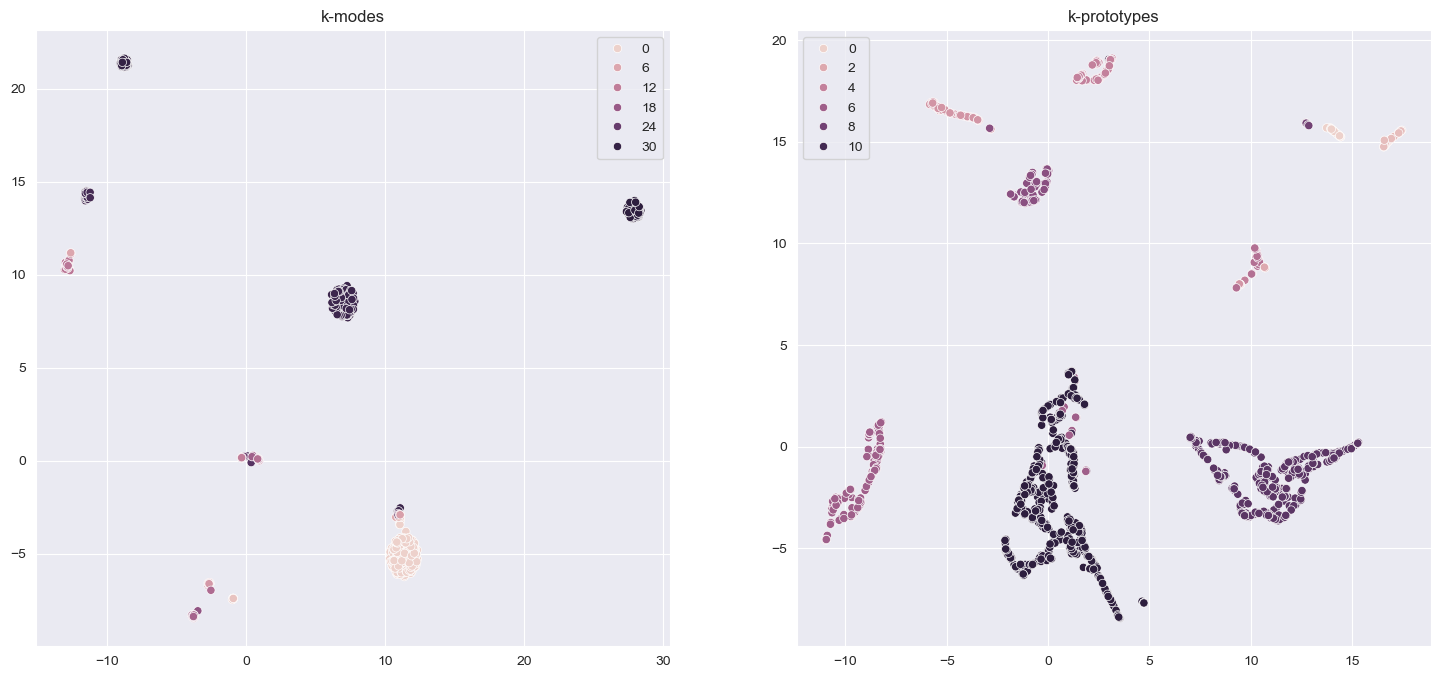

In [497]:
gm_kp = gower_matrix(X_kp)
emb_kp = umap.UMAP(metric='precomputed').fit_transform(gm_kp)
gm_km = gower_matrix(X_km)
emb_km = umap.UMAP(metric='precomputed').fit_transform(gm_km)

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
sns.scatterplot(x=emb_km[:, 0], y=emb_km[:, 1], hue=km_clusters)
plt.title('k-modes')
plt.subplot(1, 2, 2)
sns.scatterplot(x=emb_kp[:, 0], y=emb_kp[:, 1], hue=kp_clusters)
plt.title('k-prototypes')
plt.show()

Видим сравнимые метрики. Davies-Bouldin у k-proto не намного хуже. Но зато у k-proto меньшее количество кластеров и модель использует большее количество фичей, включая числовые.
### Вывод: преимущество за k-prototypes.

In [498]:
# cat_features = final_cat_cols.drop('cls').tolist()
cat_features = final_cat_cols.tolist()
num_features = final_combined_cols.drop(cat_features).tolist()
X = df[final_combined_cols].tail(1500)

In [499]:
from hyperopt import STATUS_OK
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, BisectingKMeans
import category_encoders as ce
from sklearn.compose import ColumnTransformer

models = {
    'bisecting_kmeans': BisectingKMeans,
    'kmeans': KMeans
}
encoders = {
    'one_hot_encoder': ce.OneHotEncoder,
    'binary_encoder': ce.BinaryEncoder,
    'count_encoder': ce.CountEncoder
}
def objective_compare(params):
    n_clrs = int(params['n_clusters'])
    selected_model = models[params['model']]
    selected_encoder = encoders[params['encoder']]
    
    ct = ColumnTransformer([
        ('cat', selected_encoder(), cat_features)
    ], remainder='drop')
    pl = Pipeline(steps=[
        ('ct', ct),
        ('model', selected_model(n_clusters=n_clrs, random_state=42))
    ])
    pl.fit(X)    
    clrs = pl.predict(X)
    ss, chs, dbi = scores_calc(X, clrs, 'precomputed')
    penalty = 0.1 * n_clrs
    return {
            'loss': -ss + dbi - chs + penalty,
            'status': STATUS_OK,
            'n_clusters': n_clrs,
            'silhouette': ss,
            'calinski_harabasz': chs,
            'davies_bouldin': dbi,
            'clusters': clrs,
            'selected_model': selected_model,
            'selected_encoder': selected_encoder, 
            'best_pipeline': pl
        }
space = {
    'n_clusters': hp.choice('n_clusters', range(2, 35)),
    'model': hp.choice('model', list(models.keys())),
    'encoder': hp.choice('encoder', list(encoders.keys()))
}
trials = Trials()
best = fmin(fn=objective_compare, space=space, algo=tpe.suggest, max_evals=35, trials=trials)
print(trials.best_trial['result'])

100%|██████████| 35/35 [00:22<00:00,  1.57trial/s, best loss: -4072.273952475457] 
{'loss': -4072.273952475457, 'status': 'ok', 'n_clusters': 20, 'silhouette': 0.91215193, 'calinski_harabasz': 4074.3691921893715, 'davies_bouldin': 1.0073916466307287, 'clusters': array([3, 1, 1, ..., 1, 1, 1], dtype=int32), 'selected_model': <class 'sklearn.cluster._kmeans.KMeans'>, 'selected_encoder': <class 'category_encoders.binary.BinaryEncoder'>, 'best_pipeline': Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('cat', BinaryEncoder(),
                                                  ['profile_is_child', 'genres',
                                                   'weekdays'])])),
                ('model', KMeans(n_clusters=20, random_state=42))])}


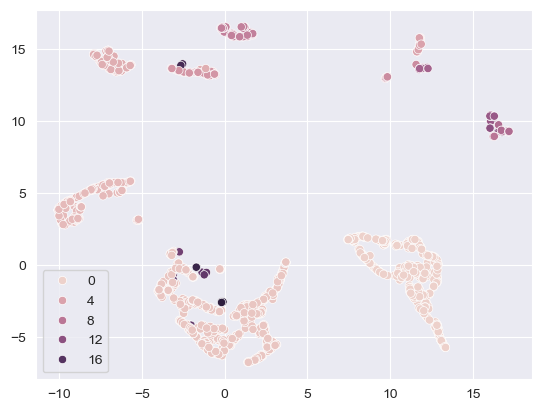

In [500]:
clusters = trials.best_trial['result']['clusters']
gm = gower_matrix(X)
emb = umap.UMAP(metric='precomputed').fit_transform(gm)
sns.scatterplot(x=emb[:, 0], y=emb[:, 1], hue=clusters)
plt.show()